In [78]:
library(plyr)
library(dplyr)
library(Matrix)
library(ggplot2)
library(tidyverse)
library(reshape2)
library(stringr)
library(ggsci)
library(cowplot)
library(RColorBrewer)
library(colorspace)
library(ggthemes)
library(scales)
library(ggrepel)
library(tidyr)
library(wesanderson)
library(ggbreak)
library(dutchmasters)



***Shannon index***



In [24]:
setwd('/home/jovyan/data/GCA/stats/')
shannon<-read.csv('TCR_shannon_v6.csv', row.names = 1)

In [25]:
temp<-shannon %>% group_by('combined_1') %>% unique()
temp <- temp %>% filter(!grepl('tissue', combined_1))

In [26]:
temp$combined_2 <- factor(temp$combined_2, levels = rev(c('negative_CD4_naive_CM_blood', 'positive_CD4_naive_CM_blood',
                                                  'negative_CD4_EM_blood', 'positive_CD4_EM_blood',
                                                 'negative_CD4_cytotoxic_blood', 'positive_CD4_cytotoxic_blood',
                                                 'negative_Treg_blood', 'positive_Treg_blood',
                                                 'negative_CD8_naive_blood', 'positive_CD8_naive_blood',
                                                 'negative_CD8_Eff_blood', 'positive_CD8_Eff_blood')))

In [27]:
temp$anno <- factor(temp$anno, levels = c('CD4_naive_CM_blood',
                                                  'CD4_EM_blood',
                                                 'CD4_cytotoxic_blood',
                                                 'Treg_blood',
                                                 'CD8_naive_blood',
                                                 'CD8_Eff_blood'))

Saving 6.67 x 6.67 in image



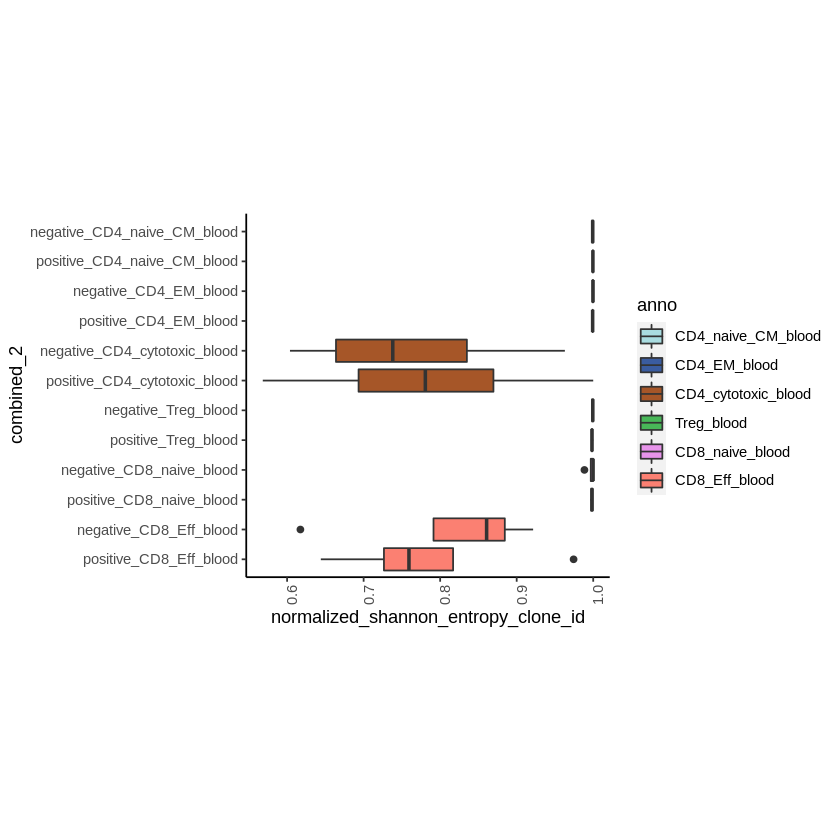

In [28]:
ggplot(temp, aes(combined_2, normalized_shannon_entropy_clone_id, fill = anno))+
geom_boxplot()+ 
scale_fill_manual(values = c('#A9DCE0',  '#3A5CA0',  '#A65628', '#48B758', '#E794EA', '#FB8072'))+
theme(axis.text.x = element_text(angle = 90))+ 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+coord_flip()+
theme(aspect.ratio = 1)

setwd('/home/jovyan/data/GCA/figures')
ggsave('shannon_index_v6.png', dpi = 300)

In [29]:
###Stats for Shannon diversity


setwd('/home/jovyan/data/GCA/stats/')
shannon<-read.csv('TCR_shannon.csv', row.names = 1)
temp<-shannon %>% group_by('combined_1') %>% unique()
temp <- temp %>% filter(!grepl('tissue', combined_1))

pval_list<-list()
for (i in unique(temp$anno)){
    temp_wilcox<-wilcox.test(temp[(temp$diagnosis == 'negative') & (temp$anno == i),]$normalized_shannon_entropy_clone_id,
           temp[(temp$diagnosis == 'positive') & (temp$anno == i),]$normalized_shannon_entropy_clone_id)$p.value
    names(temp_wilcox)<-paste0(i, '_pval')
    pval_list<-append(pval_list, temp_wilcox)
    }


Warning message in wilcox.test.default(temp[(temp$diagnosis == "negative") & (temp$anno == :
“cannot compute exact p-value with ties”


In [30]:
pval_list

$CD4_naive_CM_blood_pval
[1] 0.8857143

$CD4_EM_blood_pval
[1] 0.3005223

$CD8_Eff_blood_pval
[1] 0.8857143

$Treg_blood_pval
[1] 0.3428571

$CD4_cytotoxic_blood_pval
[1] 0.8857143

$CD8_naive_blood_pval
[1] 0.3428571



***Clones between tissues***



In [5]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data_v6.csv', row.names = 1)

In [6]:
#clones shared between tissues

clones_tissues<-tcr %>% group_by(clone_id) %>% summarise(unique_tissue = n_distinct(tissue)) %>% filter(unique_tissue>1)%>% pull(clone_id)

In [7]:
#extract metadata for those clones

tissue_shared<-tcr %>% filter(clone_id %in% clones_tissues)

In [213]:
#add tissue_cloneid metadata and count the number of events in each

tissue_shared$tissue_clone<-paste0(tissue_shared$tissue, '_', tissue_shared$clone_id)
tissue_shared_count <- tissue_shared %>% count(tissue_clone)
tissue_shared_count<-separate(tissue_shared_count, tissue_clone, into = c('tissue', 'clone_id'), sep = '_')

In [214]:
#extract clone_ids with both positive and negative diagnoses

n_diagnosis <- tissue_shared %>% group_by(clone_id) %>% summarise(n_diagnoses = n_distinct(diagnosis))
n_diagnosis$n_diagnoses[n_diagnosis$n_diagnoses > 1] <- 'mixed'
mixed_diagnosis <- n_diagnosis %>% filter(n_diagnoses == 'mixed') %>% pull(clone_id)
mixed<-data.frame(clone_id = mixed_diagnosis, diagnosis = 'mixed')

In [215]:
#extract clone_ids with single diagnoses

non_mixed<-tissue_shared %>% filter(clone_id %in% n_diagnosis$clone_id[n_diagnosis$n_diagnoses == 1]) %>% select(clone_id, diagnosis) %>% distinct(clone_id, diagnosis) %>% remove_rownames()

In [216]:
#put them together and add as metadata

diagnosis<-rbind(mixed, non_mixed)
tissue_shared_count<-merge(tissue_shared_count, diagnosis, by = 'clone_id')

In [217]:
tissue_shared_count<-tissue_shared_count %>% group_by(clone_id) %>% mutate(total_in_clone = sum(n))

In [222]:
tissue_shared_count$diagnosis_sign[tissue_shared_count$diagnosis == 'negative']<-'-'
tissue_shared_count$diagnosis_sign[tissue_shared_count$diagnosis == 'positive']<-'+'
tissue_shared_count$diagnosis_sign[tissue_shared_count$diagnosis == 'mixed']<-'mix'

In [223]:
tissue_shared_count$id <-tissue_shared_count %>% arrange(fct_reorder(clone_id, total_in_clone), .desc = TRUE) %>% group_by(clone_id) %>% group_indices(clone_id) 

In [224]:
label_data <- tissue_shared_count %>% distinct(clone_id, total_in_clone, id, diagnosis_sign, total_in_clone)
label_data <- label_data %>% arrange(fct_reorder(clone_id, total_in_clone))
label_data$position<-seq(1:nrow(label_data))
angle<-360-(((360/54)*label_data$position)+90)
label_data$angle<-ifelse(angle < -90, angle+180, angle)

In [264]:
dim(tissue_shared_count)

[1] 108   7

Saving 6.67 x 6.67 in image



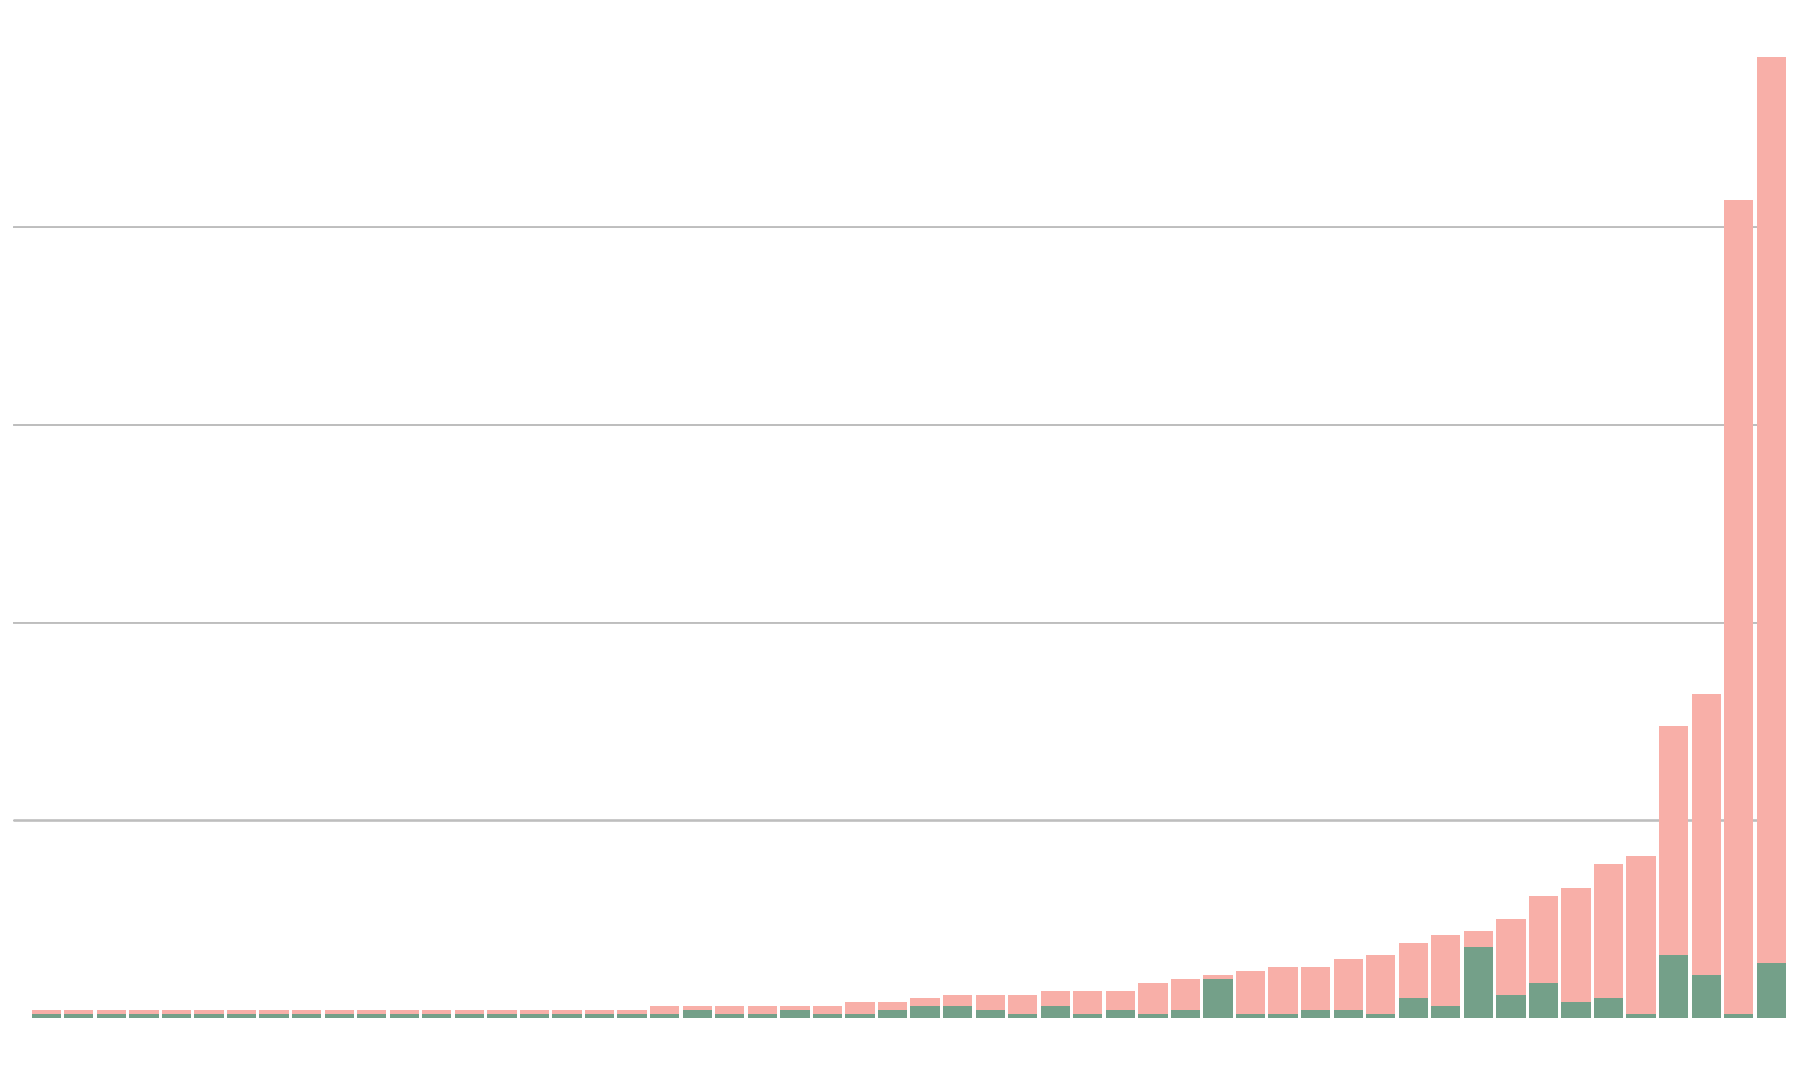

In [266]:
options(repr.plot.width=15, repr.plot.height=9)

ggplot(tissue_shared_count, aes(x=fct_reorder(clone_id, total_in_clone), y=n, fill = tissue)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity") +
scale_fill_manual(values = c(wes_palette("Royal2")[[3]], wes_palette("Royal2")[[5]]))+
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
#   plot.margin = unit(rep(-1,4), "cm"),
    legend.position = 'none') + 
geom_segment(data=plot_data, aes(x = 0, xend = 54, y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = 54, y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = 54, y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = 54, y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
  geom_bar(stat="identity")

# geom_text(data=label_data, aes(x=fct_reorder(clone_id, total_in_clone), y=total_in_clone+10, label=diagnosis_sign), 
#           color="black",alpha=0.6, size=4, angle = 90, inherit.aes = FALSE, fontface = 'bold')

setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_across_compartments.png', dpi = 300)


In [237]:
diagnosis<-tissue_shared_count %>% select(clone_id, diagnosis_sign, total_in_clone) %>% distinct()

In [238]:
diagnosis$row<-1

Saving 6.67 x 6.67 in image



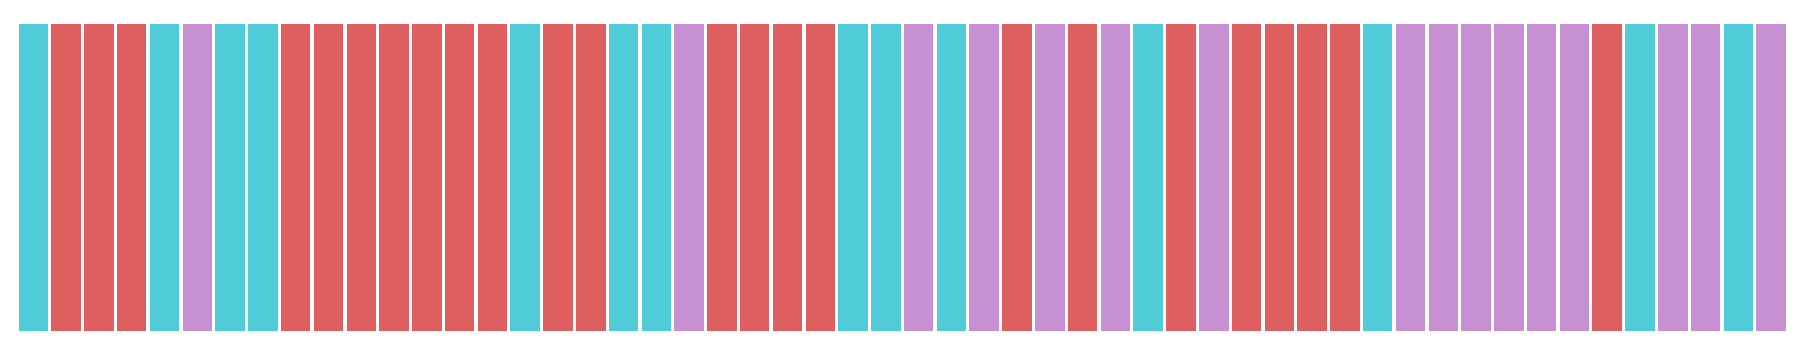

In [272]:
options(repr.plot.width=15, repr.plot.height=3)

ggplot(diagnosis, aes(x=fct_reorder(clone_id, total_in_clone), y=row, fill = diagnosis_sign)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat = 'identity')+
scale_fill_manual(values = c('#50cbd8', '#dd5f5f', '#C690D3'))+ 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
     axis.text = element_blank(), axis.title = element_blank(), legend.position = 'none', axis.line=element_blank(), axis.ticks=element_blank())


setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_across_compartments_key.png', dpi = 300)

In [989]:
wes_palette("BottleRocket1")[[2]]

[1] "#5F5647"

In [ ]:


***Extract clone IDs by consensus annotation***



In [146]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data.csv', row.names = 1)

In [147]:
tcr$cell<-rownames(tcr)

In [148]:
#clones shared between donors

donor_shared <- tcr %>% group_by(clone_id) %>% summarise(unique_clones = n_distinct(patient_id)) %>% filter(unique_clones>1) %>% pull(clone_id)

In [1017]:
temp<- tcr %>% filter(clone_id %in% donor_shared)

In [1018]:
meta<-temp %>% select(clone_id, tissue, diagnosis) %>% distinct(clone_id, tissue,diagnosis)
meta_2 <-temp %>% count(clone_id)

In [1019]:
anno_table<-as.data.frame.matrix(table(temp$clone_id, temp$anno))
anno_table$V1<-NULL
anno_table$consensus<-colnames(anno_table)[apply(anno_table,1,which.max)]

In [1020]:
anno_table$clone_id<-rownames(anno_table)

In [1021]:
anno_table<-merge(anno_table, meta, by = 'clone_id')

In [1022]:
anno_table<-merge(anno_table, meta_2, by = 'clone_id')

In [1023]:
anno_table$clone_id<-as.factor(anno_table$clone_id)

In [1024]:
anno_table<-anno_table %>% arrange(consensus, n)
anno_table$clone_id<-factor(anno_table$clone_id, levels = anno_table$clone_id)



***Export data for GLIPH***



In [28]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data_v6.csv', row.names = 1)

In [29]:
temp<-tcr %>% 
select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, IR_VJ_1_junction_aa, patient_id, diagnosis, clone_id)
temp$subject<-paste0(temp$patient_id, ':', temp$diagnosis)
temp<-temp %>% select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, IR_VJ_1_junction_aa, subject)


In [30]:
colnames(temp)<-c('CDR3b', 'TRBV', 'TRBJ', 'CDR3a', 'subject:condition')

In [31]:
meta<-as.data.frame(table(temp$CDR3b))
colnames(meta)<-c('CDR3b', 'count')

In [32]:
temp<-merge(temp, meta, by = 'CDR3b')

In [33]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
write.table(temp, 'tcr_for_gliph.txt', sep = '\t', row.names = FALSE)



***Analyse GLIPH data***



In [54]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data_v6.csv', row.names = 1)

In [55]:
tcr$cell<-rownames(tcr)

In [56]:
#clones shared between donors

donor_shared <- tcr %>% group_by(clone_id) %>% summarise(unique_clones = n_distinct(patient_id)) %>% filter(unique_clones>1) %>% pull(clone_id)

In [57]:
length(donor_shared)

[1] 149

In [58]:
temp<- tcr %>% filter(clone_id %in% donor_shared)

In [59]:
temp<-temp %>% 
select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, IR_VJ_1_junction_aa, patient_id, diagnosis, clone_id)
temp$subject<-paste0(temp$patient_id, ':', temp$diagnosis)
temp<-temp %>% select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, IR_VJ_1_junction_aa, subject)


In [60]:
colnames(temp)<-c('CDR3b', 'TRBV', 'TRBJ', 'CDR3a', 'subject:condition')

In [61]:
meta<-as.data.frame(table(temp$CDR3b))
colnames(meta)<-c('CDR3b', 'count')

In [62]:
temp<-merge(temp, meta, by = 'CDR3b')

In [63]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
gliph<-read.csv('gliph_output_v6.csv')

In [64]:
gliph<-gliph %>% filter(Fisher_score<0.05)

In [65]:
temp<-gliph %>% filter(TcRb %in% temp$CDR3b)

In [66]:
temp3<-gliph %>% filter(pattern %in% temp$pattern)

In [67]:
temp3<-temp3 %>% group_by(pattern) %>% count(Sample)

In [68]:
library(forcats)

In [69]:
temp3<-temp3 %>% group_by(pattern) %>% mutate(total = sum(n)) %>% arrange(desc(total))


In [70]:
unique(temp3$Sample)

[1] "GCA100:positive" "GCA101:negative" "GCA102:negative" "GCA47:positive" 
[5] "GCA54:positive"  "GCA55:positive"  "GCA70:negative"  "GCA86:positive" 
[9] "GCA92:negative"

In [71]:
temp3$Sample <-factor(temp3$Sample, levels = c('GCA102:negative', 'GCA101:negative', 'GCA100:positive', 'GCA92:negative', 'GCA86:positive', 'GCA70:negative', 'GCA47:positive',
                                              'GCA54:positive', 'GCA55:positive'))

In [72]:
temp3$pattern <- factor(temp3$pattern, levels = unique(temp3$pattern))

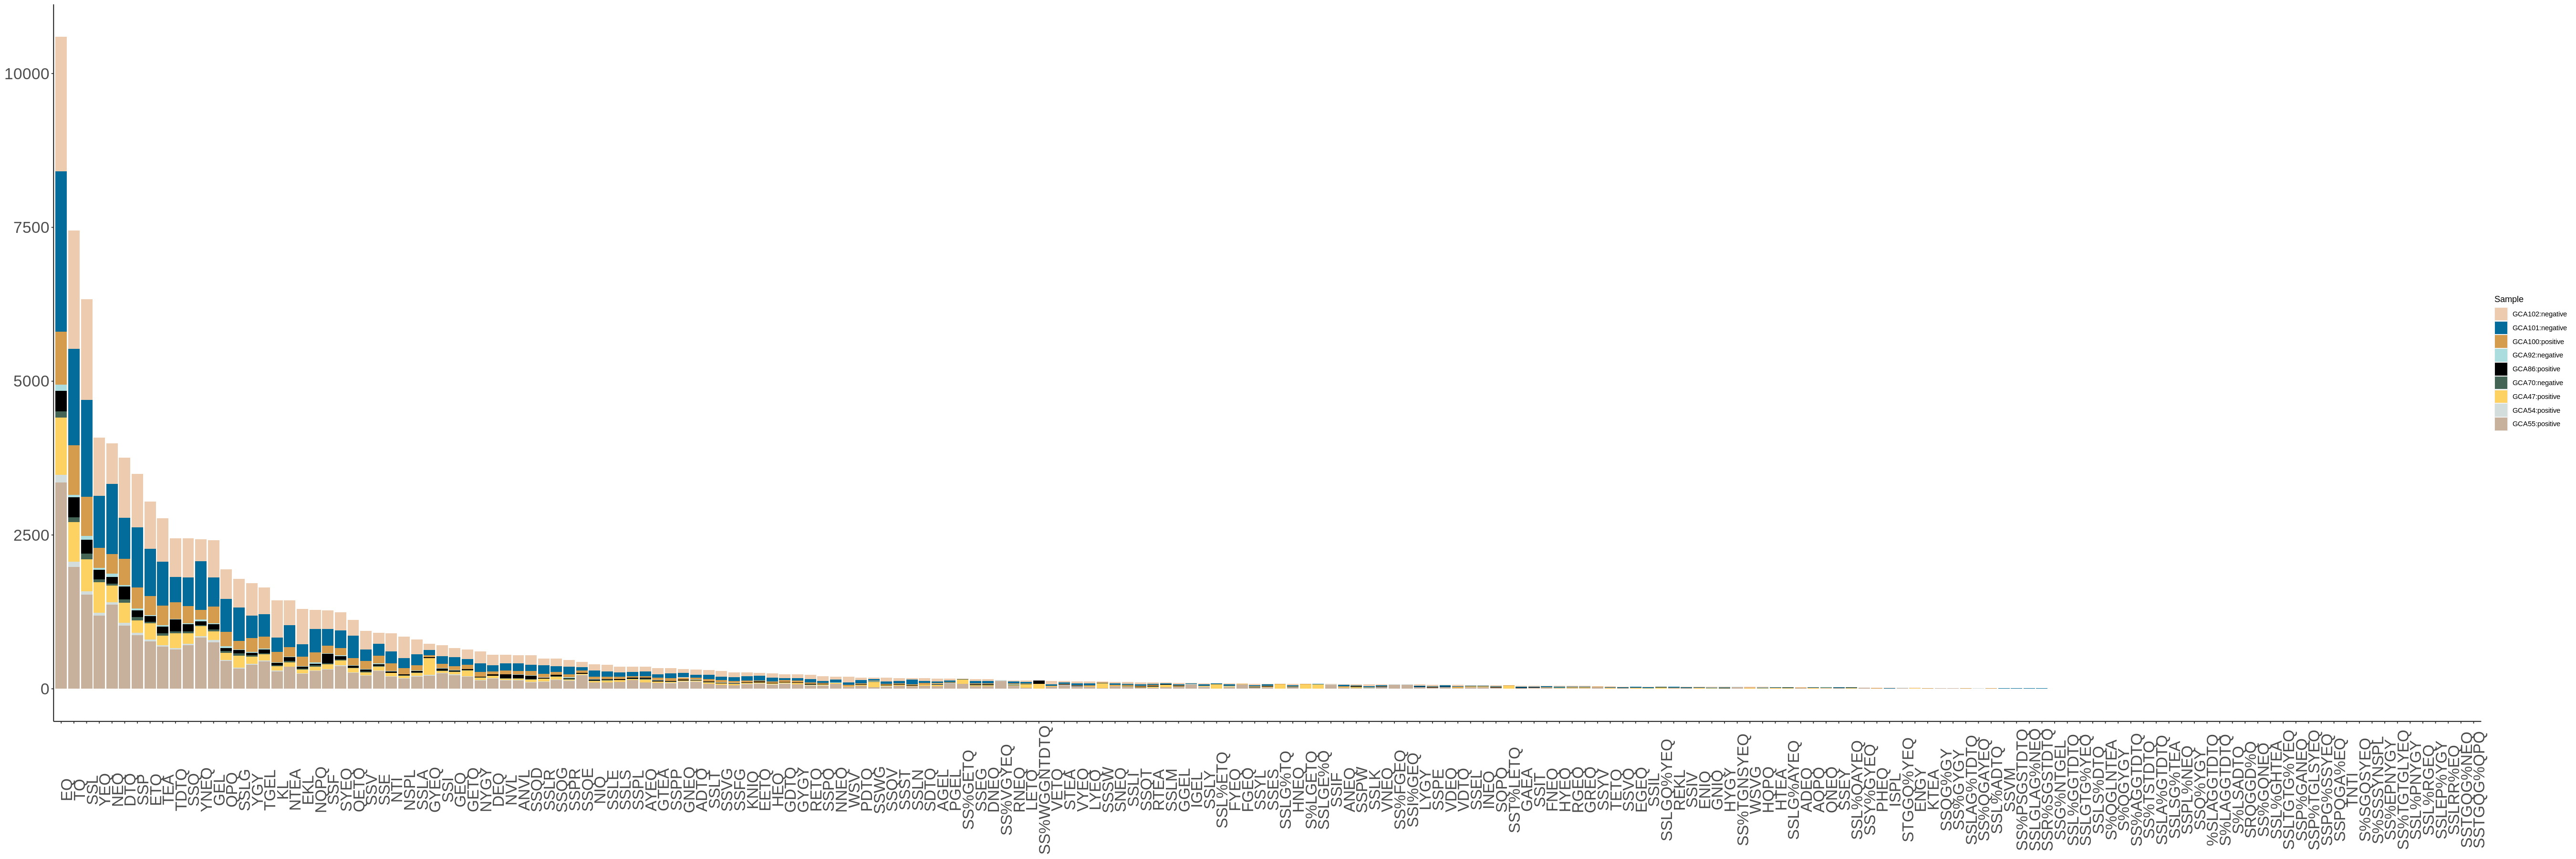

In [77]:
options(repr.plot.width=45, repr.plot.height=15)
ggplot(temp3, aes(pattern, n, fill = Sample))+geom_bar(stat = 'identity')+theme(axis.text.x = element_text(angle = 90))+ 
theme(panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      panel.background = element_blank(), 
      axis.line = element_line(colour = "black"),
     axis.title = element_blank(),
     axis.text = element_text(size =20))+
scale_fill_manual(values = c("#ECCBAE", "#046C9A", "#D69C4E", "#ABDDDE", "#000000", "#446455", "#FDD262", "#D3DDDC", "#C7B19C"))

setwd('/home/jovyan/data/GCA/figures')
ggsave('gliph_figure_v6.png', dpi = 300, width = 45, height = 15)



***TCRDist/DeepTCR export***



In [72]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data.csv', row.names = 1)

In [73]:
tcr<-tcr %>% filter(tissue == 'tissue' & patient_id %in% c('GCA54', 'GCA55'))

In [74]:
donor_shared <- tcr %>% group_by(clone_id) %>% summarise(unique_clones = n_distinct(patient_id)) %>% filter(unique_clones>1) %>% pull(clone_id)

tcr$clonality<-'non_clonal'
tcr$clonality[tcr$clone_id %in% donor_shared] <- 'clonal'

In [75]:
temp<-tcr %>% 
select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, IR_VJ_1_junction_aa, patient_id, diagnosis, clone_id, clonality)
temp$subject<-paste0(temp$patient_id, ':', temp$diagnosis)
temp<-temp %>% select(IR_VDJ_1_junction_aa, IR_VDJ_1_v_call, IR_VDJ_1_j_call, clonality)


In [76]:
colnames(temp)<-c('beta', 'v_beta', 'j_beta', 'clonality')

#'beta', 'counts', 'v_beta', 'j_beta'

In [77]:
meta<-as.data.frame(table(temp$beta))
colnames(meta)<-c('beta', 'count')
temp<-merge(temp, meta, by = 'beta')
temp<-temp %>% select(beta, count, v_beta, j_beta, clonality)

In [78]:
clones<-temp %>% filter(clonality == 'clonal')
non_clones<-temp %>% filter(clonality == 'non_clonal')

In [79]:
setwd('/home/jovyan/data/GCA/TCRDist/clonality/clonal')
write.table(clones, 'clonal.tsv', sep = '\t')

setwd('/home/jovyan/data/GCA/TCRDist/clonality/non_clonal')
write.table(non_clones, 'non_clonal.tsv', sep = '\t')



***Shared clones between donors***



In [150]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data_v6.csv', row.names = 1)

In [151]:
tcr$cell<-rownames(tcr)

In [152]:
#clones shared between donors

donor_shared <- tcr %>% group_by(clone_id) %>% summarise(unique_clones = n_distinct(patient_id)) %>% filter(unique_clones>1) %>% pull(clone_id)

In [153]:
length(donor_shared)

[1] 149

In [13]:
donor_shared_meta <- tcr %>% filter(clone_id %in% donor_shared)

In [14]:
plot_data<-donor_shared_meta %>% select(patient_id, clone_id, tissue, diagnosis) %>% group_by(patient_id, clone_id, tissue, diagnosis) %>% summarise(count = n())

`summarise()` has grouped output by 'patient_id', 'clone_id', 'tissue'. You can override using the `.groups` argument.



In [15]:
#add consensus annotation to the plotting data

anno_table<-as.data.frame.matrix(table(donor_shared_meta$clone_id, donor_shared_meta$anno))
anno_table$V1<-NULL
anno_table$consensus<-colnames(anno_table)[apply(anno_table,1,which.max)]
anno_table$clone_id<-rownames(anno_table)
temp<-anno_table %>% select(clone_id, consensus) %>% remove_rownames()

plot_data<-merge(plot_data, temp, by = 'clone_id', how = 'left')

In [16]:
plot_data$clone_id<-as.factor(plot_data$clone_id)

In [17]:
unique(plot_data$consensus)

[1] "CD8_naive_blood"      "CD8_Eff_blood"        "CD8_tissue"          
 [4] "CD4_1_tissue"         "CD4_cytotoxic_blood"  "MyoFB_tissue"        
 [7] "CD4_naive_CM_blood"   "Treg_blood"           "CD4_EM_blood"        
[10] "Endothelium_1_tissue"

In [18]:
plot_data<-plot_data %>% filter(!(consensus %in% c('Endothelium_1_tissue', 'MyoFB_tissue')))

In [19]:
plot_data$consensus<-factor(plot_data$consensus, levels = c('CD4_naive_CM_blood', 'CD4_EM_blood', 'CD4_cytotoxic_blood', 'Treg_blood',
                                                             'CD8_naive_blood', 'CD8_Eff_blood',
                                                             'CD4_1_tissue', 'CD8_tissue'))

In [20]:
plot_data <- plot_data %>% group_by(clone_id) %>% mutate(total_in_clone = sum(count))

In [21]:
plot_data<-plot_data %>% arrange(consensus, total_in_clone)
plot_data$clone_id<-factor(plot_data$clone_id, levels = unique(plot_data$clone_id))

In [27]:
temp<-plot_data %>% filter(tissue == 'tissue') %>% group_by(clone_id) %>% summarise(n_distinct(diagnosis))
table(temp$`n_distinct(diagnosis)`)


 1  2 
67 64 

Saving 49 x 6.67 in image



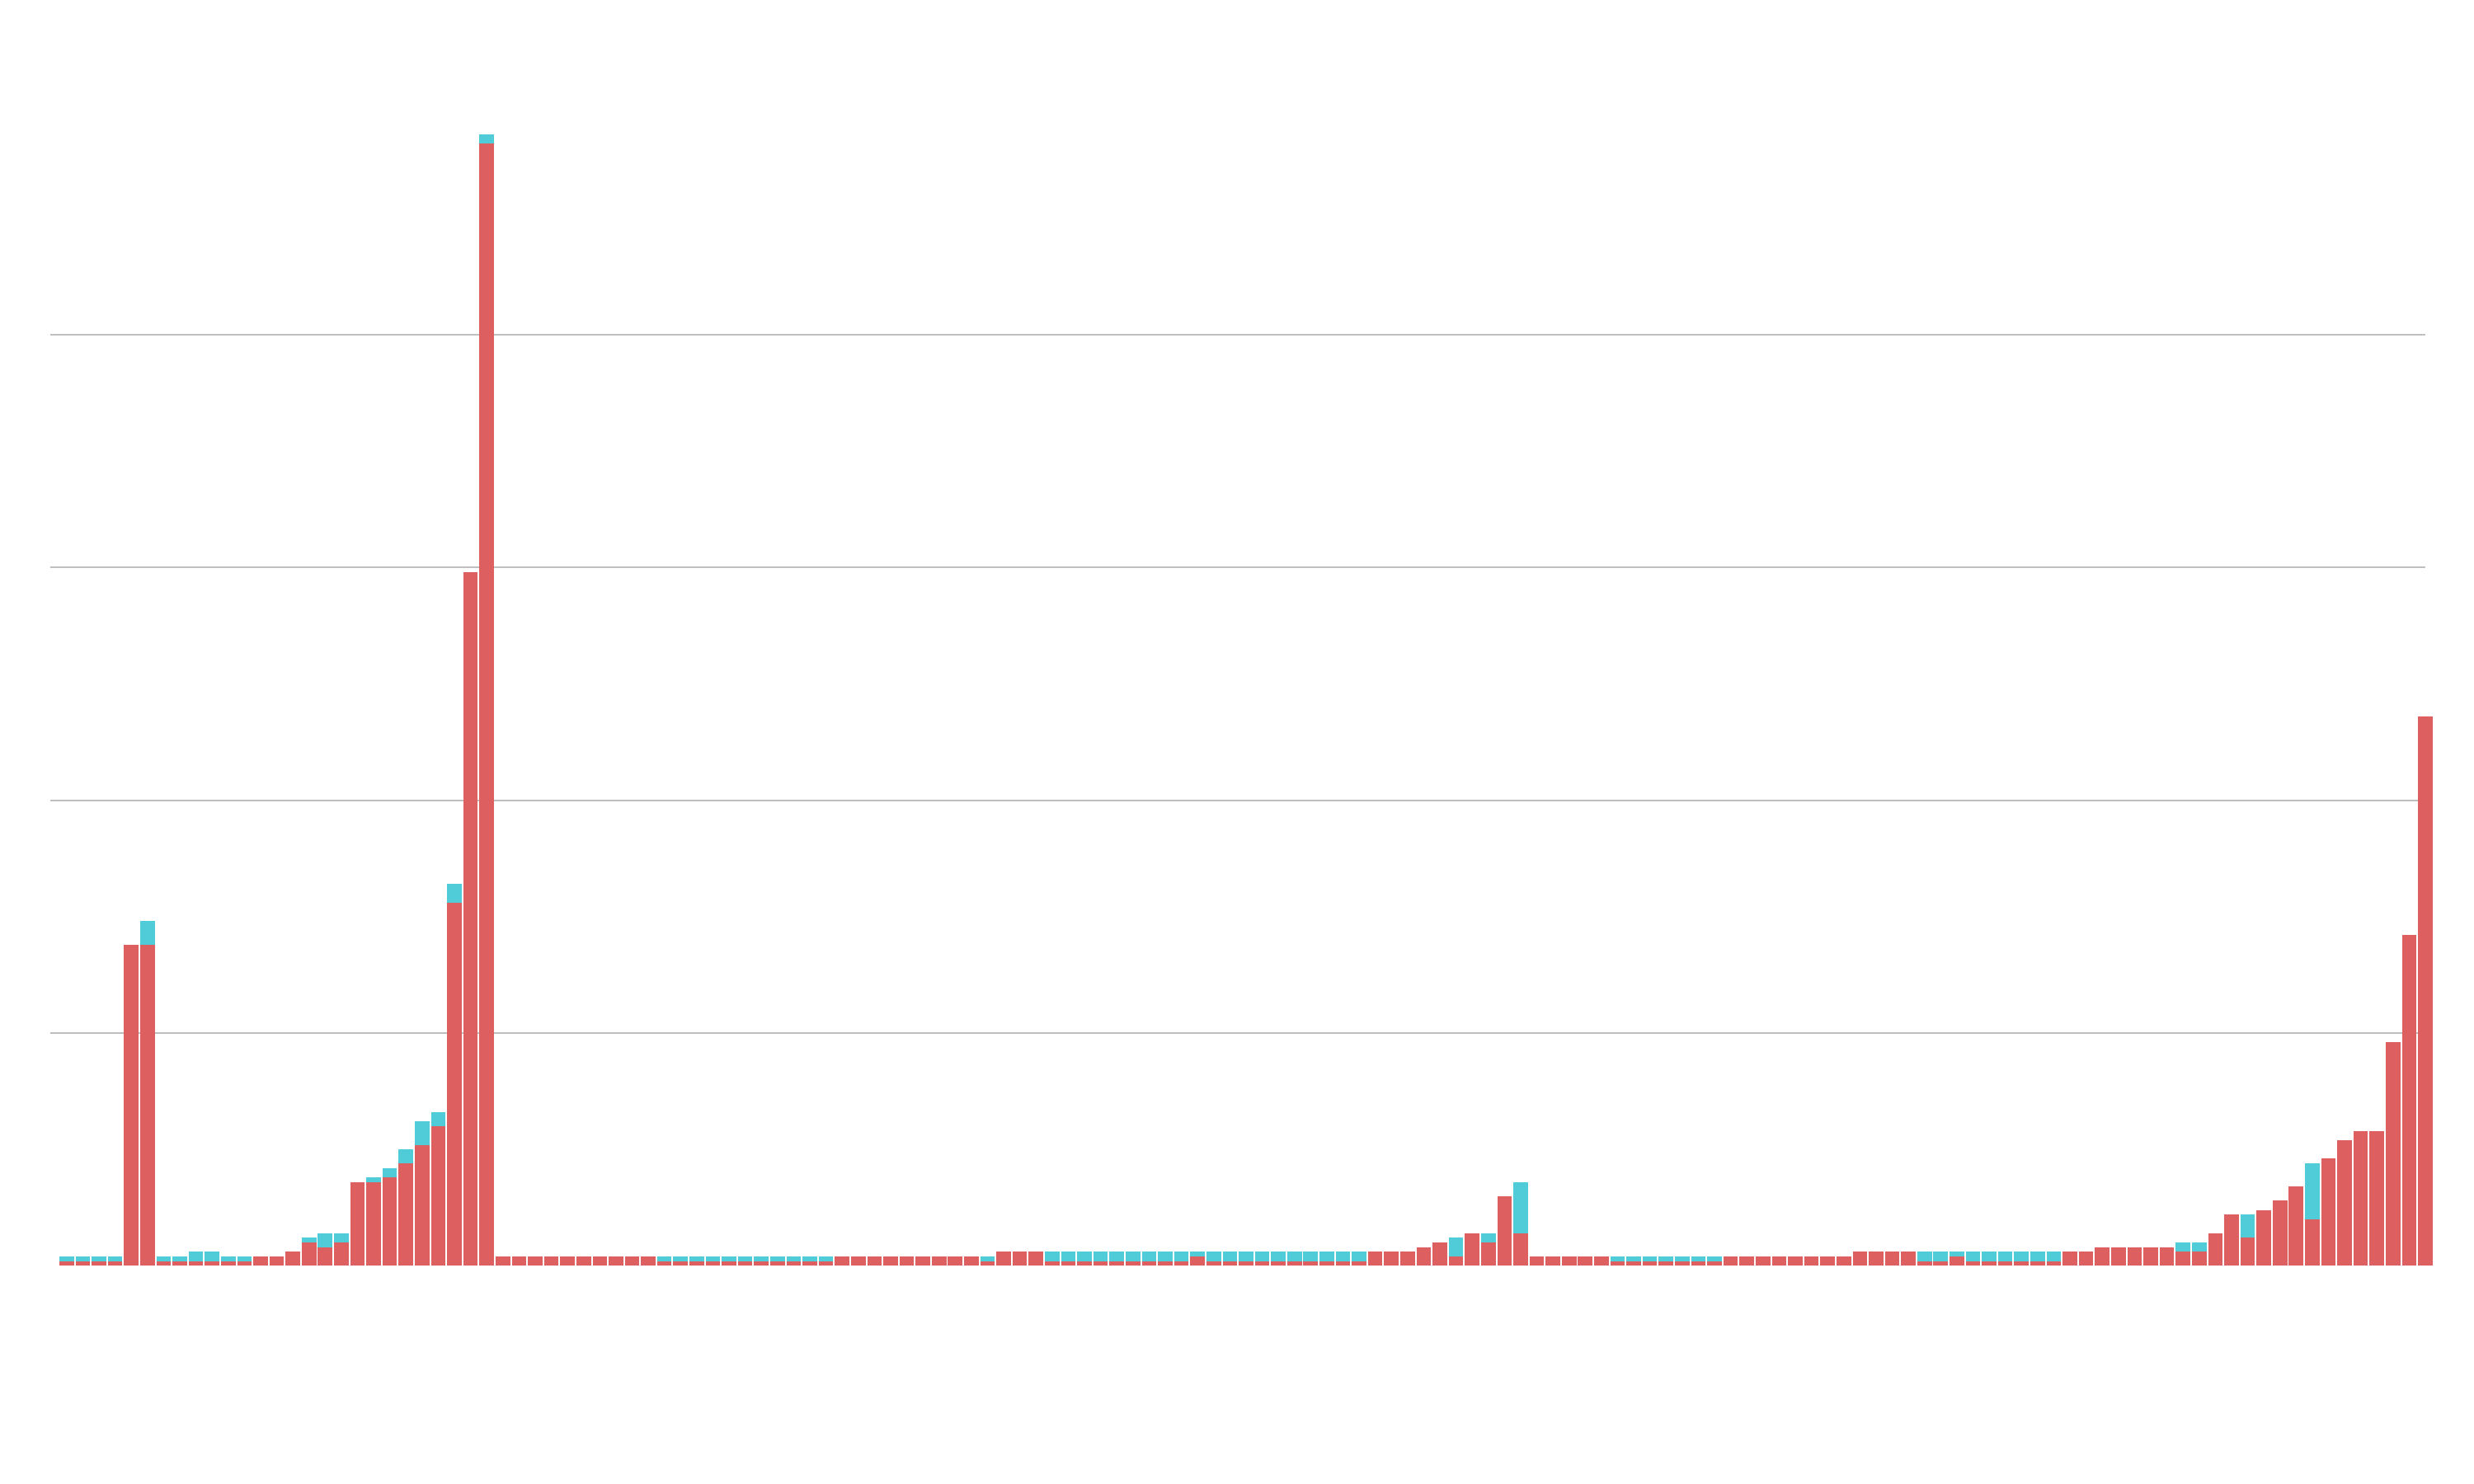

In [172]:
options(repr.plot.width=25, repr.plot.height=15)
ggplot(plot_data, aes(x=clone_id, y=count, fill = diagnosis)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar

  geom_bar(stat="identity") +

  ylim(-20,250) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
#   plot.margin = unit(rep(-1,4), "cm"),
    legend.position = 'none',
    plot.margin=unit(c(1,1,1.5,1.2),"cm")) + 
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_bar(stat="identity") +
scale_fill_manual(values = c('#50cbd8', '#dd5f5f'))
#scale_y_break(c(150, 240))+
#coord_polar(start = 0)
#scale_y_log10()+ 
#theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size =10))
                                      
setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_between_donors_v6_diagnosis.png', dpi = 300, width = 49)

In [165]:
plot_data$consensus<-factor(plot_data$consensus, levels = c('CD4_naive_CM_blood', 'CD4_EM_blood', 'CD4_cytotoxic_blood', 'Treg_blood',
                                                             'CD8_naive_blood', 'CD8_Eff_blood',
                                                             'CD4_1_tissue', 'CD8_tissue'))

Saving 49 x 6.67 in image



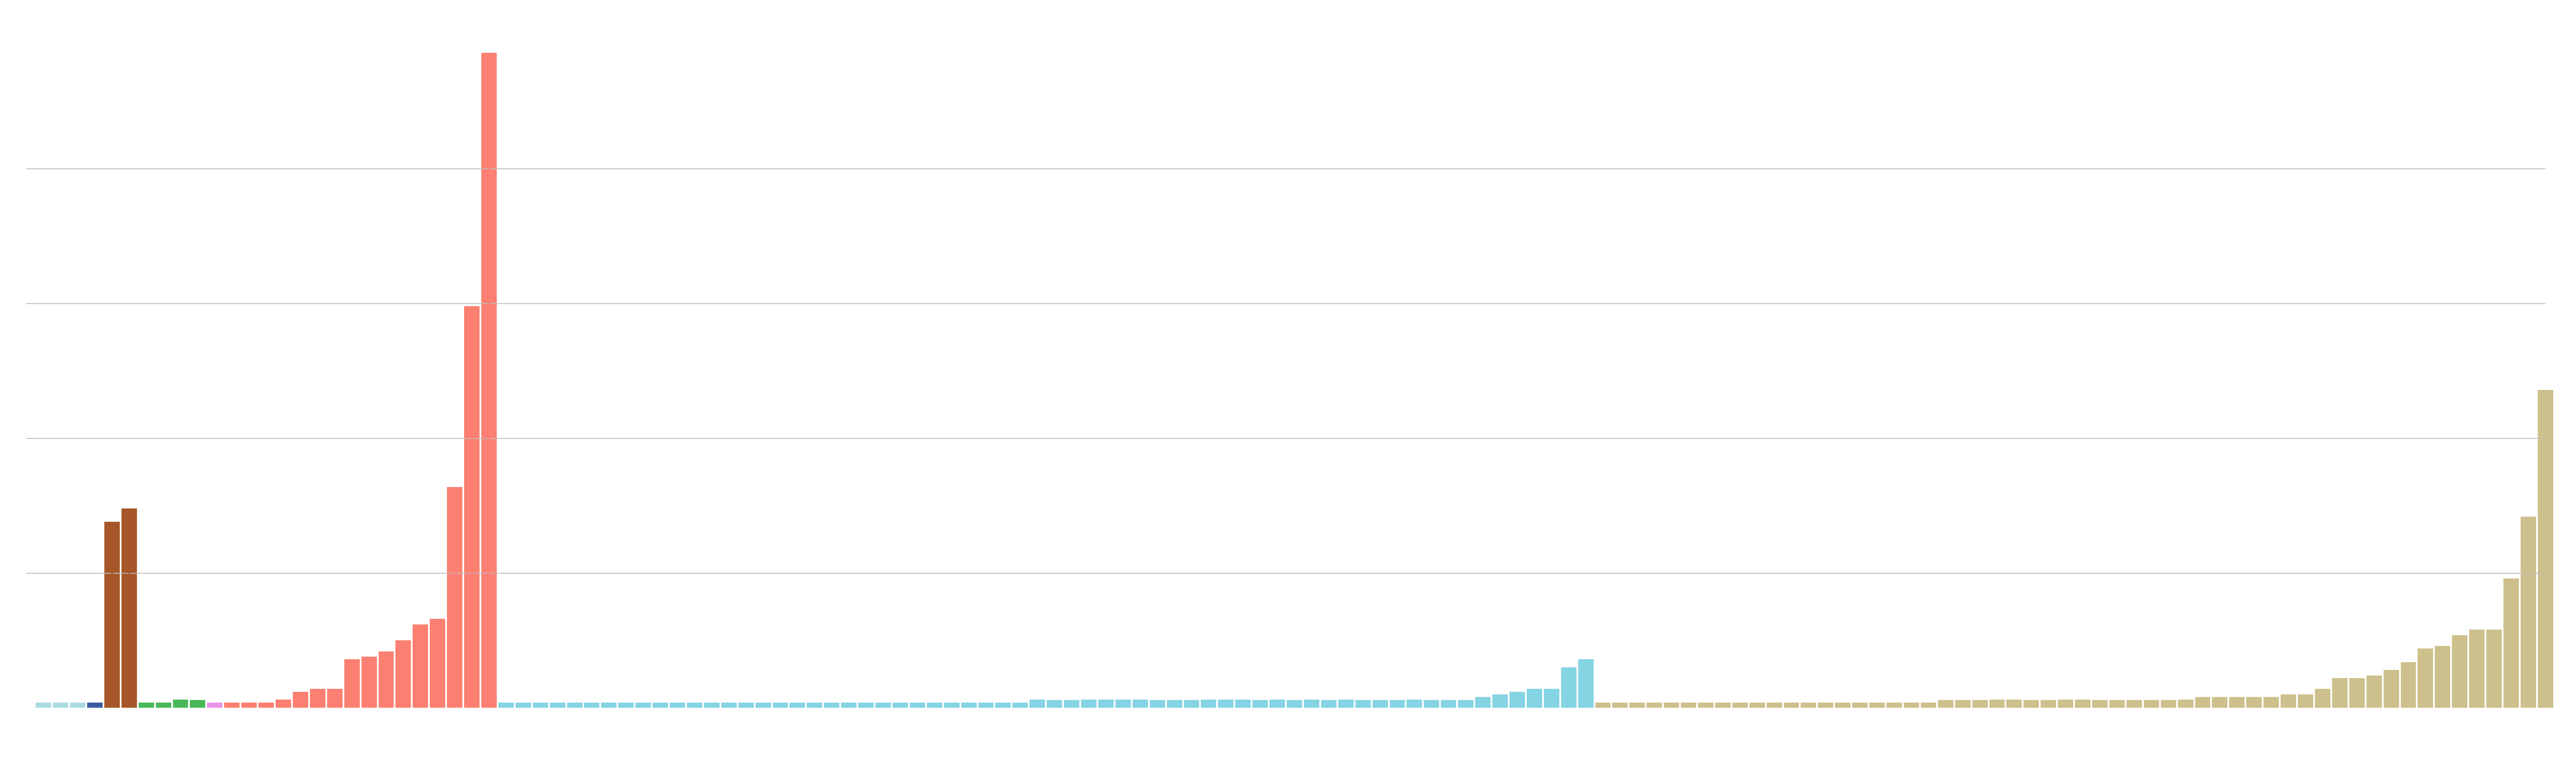

In [173]:
options(repr.plot.width=50, repr.plot.height=15)

ggplot(plot_data, aes(x=clone_id, y=count, fill = consensus)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity") +
#  ylim(-20,250) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
plot.margin=unit(c(1,1,1.5,1.2),"cm"),
  legend.position = 'none') + 
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_bar(stat="identity", width = 0.1) +
expand_limits(x = 100)+
scale_fill_manual(values = c('#A9DCE0',  '#3A5CA0',  '#A65628', '#48B758', '#E794EA', '#FB8072', '#85D4E3', '#CDC08C'))

#scale_y_break(c(150, 240))+
#coord_polar(start = 0)
#scale_y_log10()+ 
#theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size =10))

setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_between_donors_v6_celltype.png', dpi = 300, width = 49)

Saving 49 x 6.67 in image



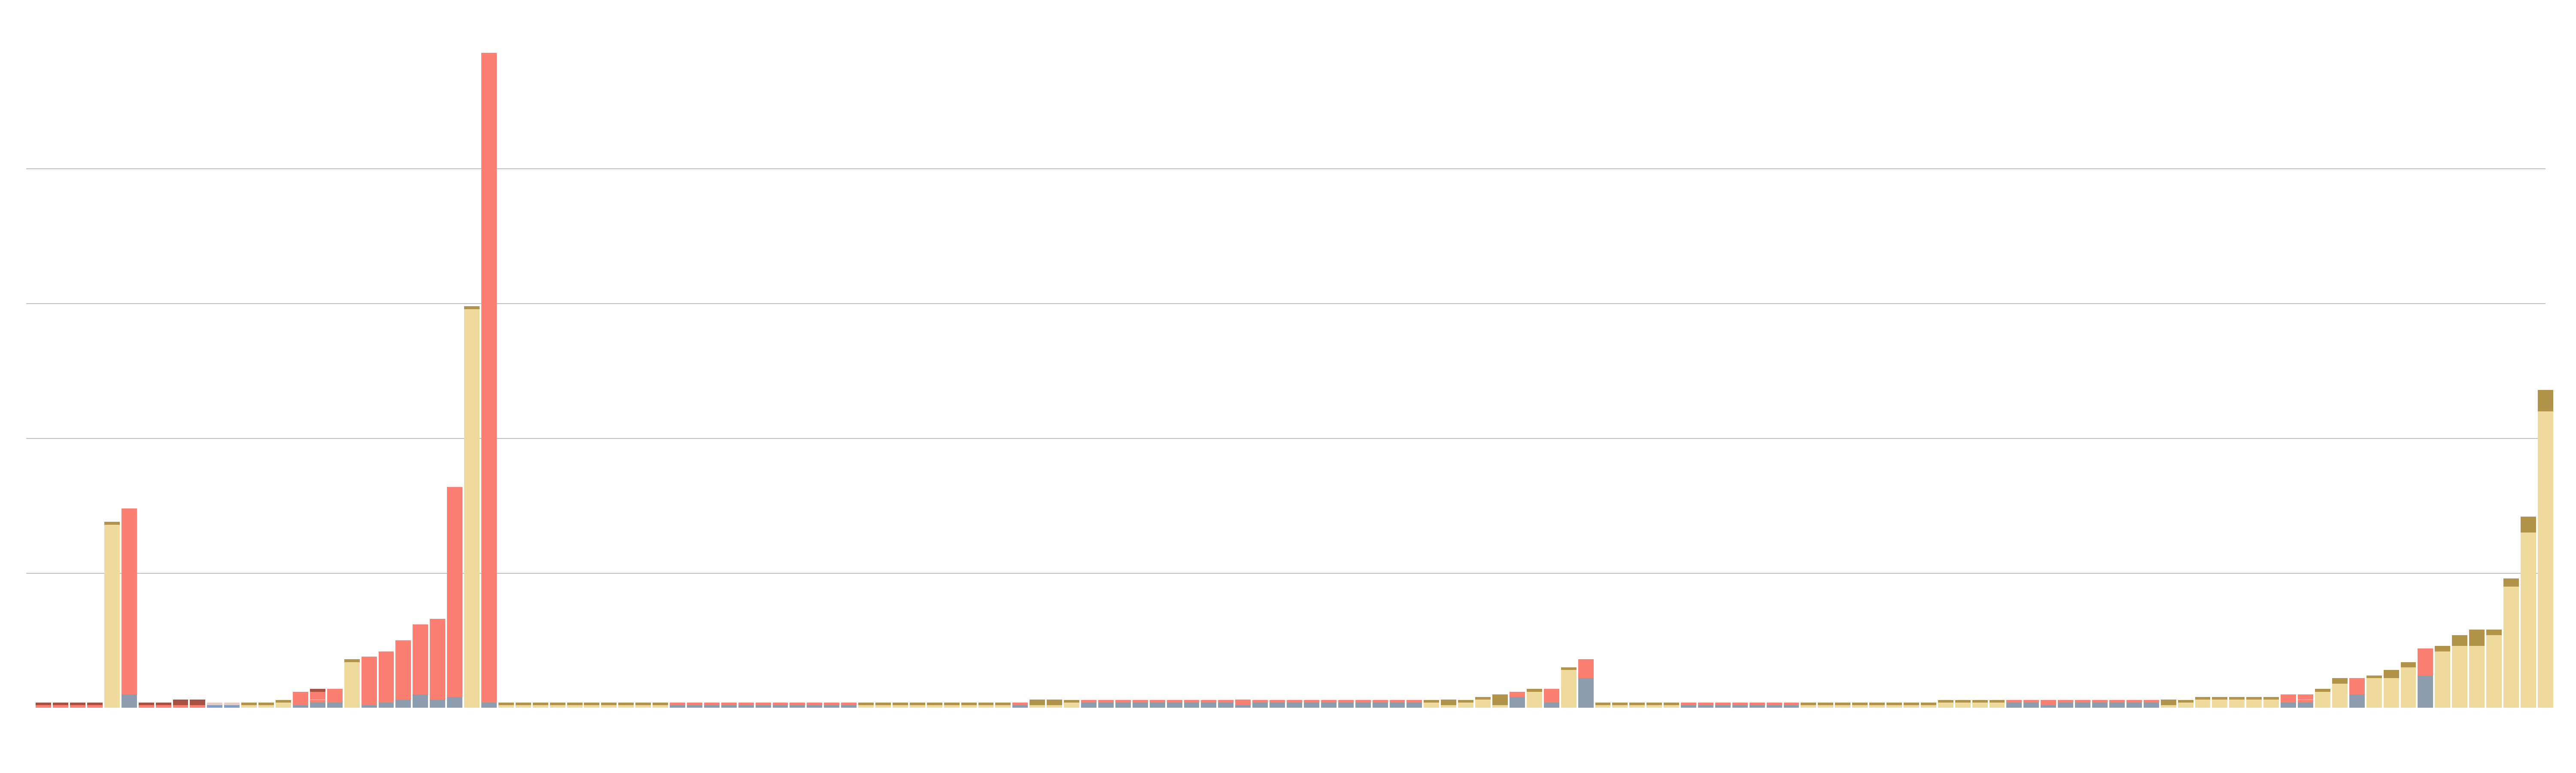

In [185]:
ggplot(plot_data, aes(x=clone_id, y=count, fill = patient_id)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity") +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
      legend.position = 'none',
    plot.margin=unit(c(1,1,1.5,1.2),"cm")) + 
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
  geom_bar(stat="identity")+
#coord_polar(start = 0)+
scale_fill_manual(values = c('#A65141',  '#E7CDC2',  '#FB8072', '#B1934A', '#EEDA9D', '#8B9DAF', '#80A0C7', '#85D4E3', '#CDC08C'))



setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_between_donors_v6_donor.png', dpi = 300, width = 49)

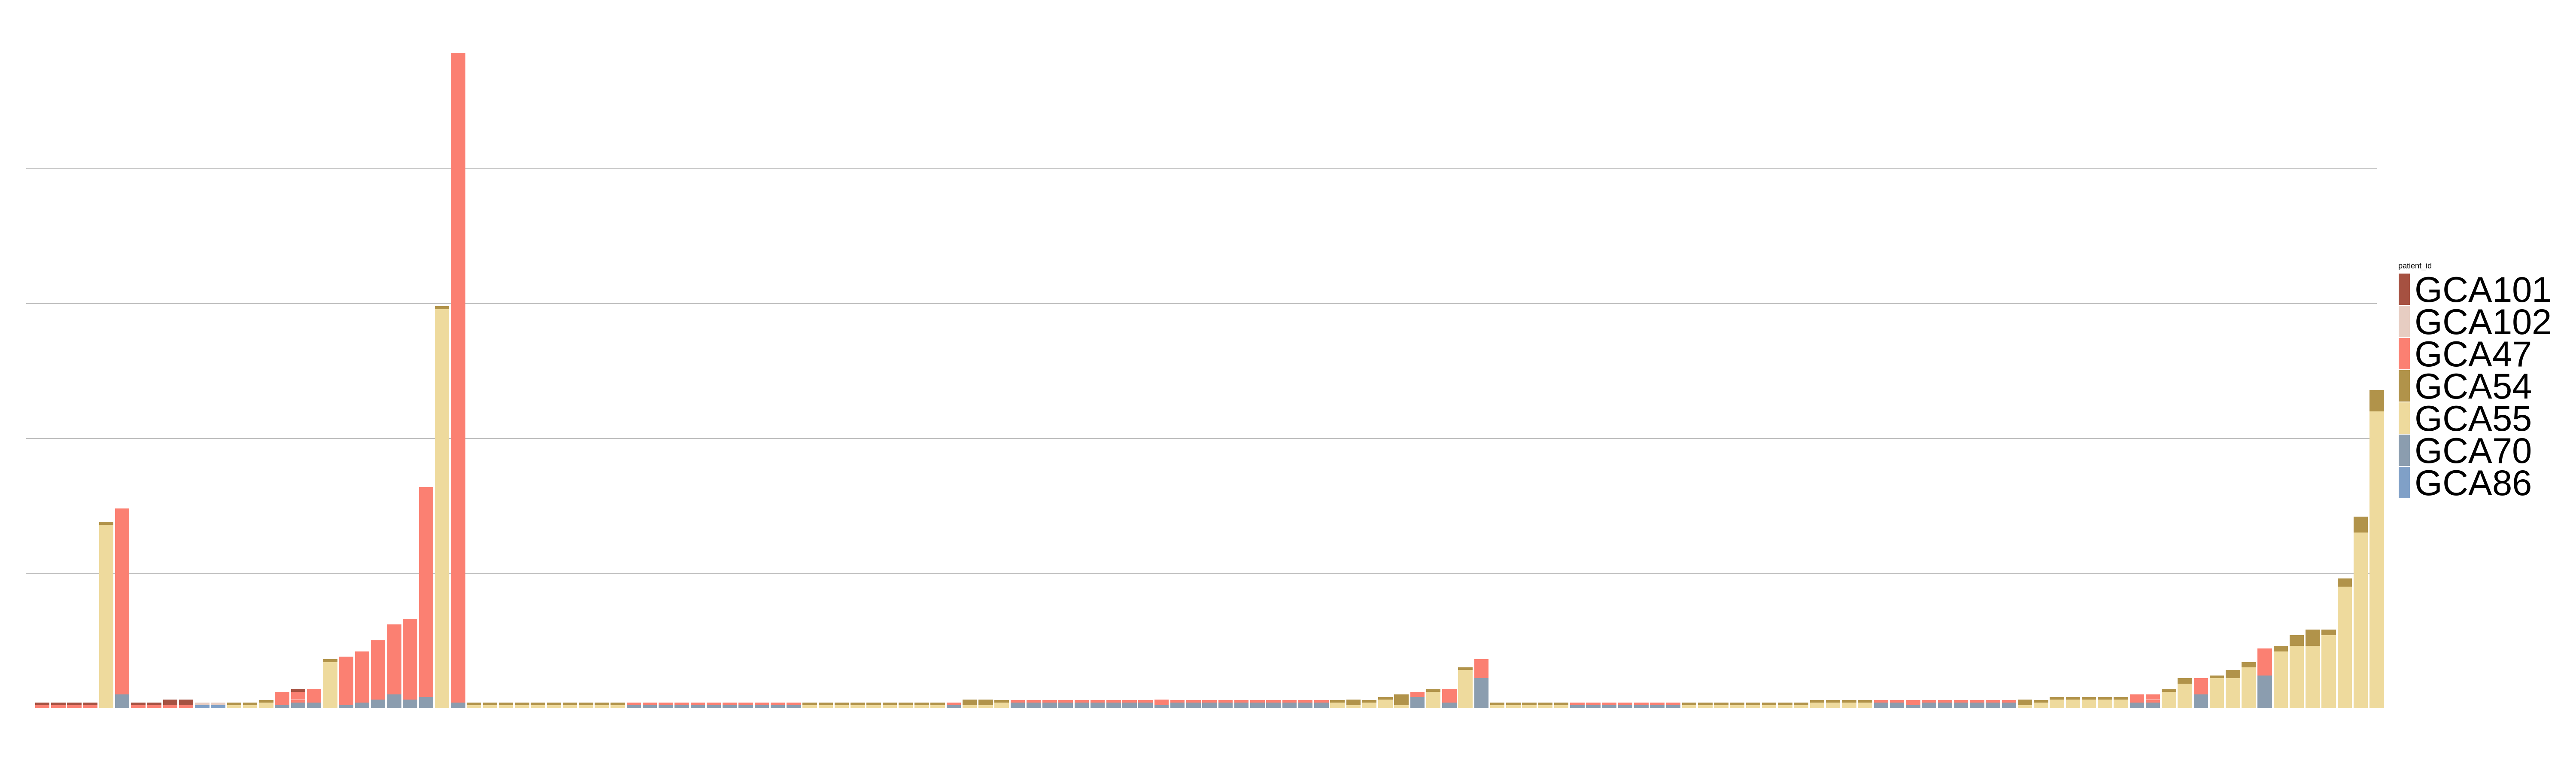

In [187]:
ggplot(plot_data, aes(x=clone_id, y=count, fill = patient_id)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity") +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
    plot.margin=unit(c(1,1,1.5,1.2),"cm"),
  legend.text = element_text(size = 50)) + 
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
  geom_bar(stat="identity")+
#coord_polar(start = 0)+
scale_fill_manual(values = c('#A65141',  '#E7CDC2',  '#FB8072', '#B1934A', '#EEDA9D', '#8B9DAF', '#80A0C7', '#85D4E3', '#CDC08C'))

In [35]:
list(dutchmasters$pearl_earring)

[[1]]
        red(lips)              skin      blue(scarf1)      blue(scarf2) 
        "#A65141"         "#E7CDC2"         "#80A0C7"         "#394165" 
     white(colar)       gold(dress)      gold(dress2) black(background) 
        "#FCF9F0"         "#B1934A"         "#DCA258"         "#100F14" 
     grey(scarf3)    yellow(scarf4)                   
        "#8B9DAF"         "#EEDA9D"         "#E8DCCF"

In [299]:
plot_data$log_total<-log(plot_data$total_in_clone)

In [122]:
length(unique(plot_data$clone_id))

[1] 147



***VDJdb analysis***



In [137]:
setwd('/home/jovyan/data/GCA/TCR_analysis/')
vdj = read.csv('vdjdb_database.tsv', sep = '\t')

In [139]:
a_gene <- vdj %>% filter(Gene == 'TRA') %>% rename('IR_VJ_1_junction_aa' = 'CDR3', 'IR_VJ_1_locus' = 'Gene', 'IR_VJ_1_v_call' = 'V', 'IR_VJ_1_j_call' = 'J', 
                                         'antigen.epitope' = 'Epitope', 'antigen.gene' = 'Epitope.gene', 'antigen.species' = 'Epitope.species',
                                         'mhc.a' = 'MHC.A', 'mhc.class' = 'MHC.class')

In [140]:
a_gene <- a_gene %>% select('complex.id', 'IR_VJ_1_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_1_v_call', 'IR_VJ_1_j_call', 
                                         'antigen.epitope', 'antigen.gene', 'antigen.species',
                                         'mhc.a')

In [141]:
b_gene <- vdj %>% filter(Gene == 'TRB') %>% rename('IR_VDJ_1_junction_aa' = 'CDR3', 'IR_VDJ_1_locus' = 'Gene', 'IR_VDJ_1_v_call' = 'V', 'IR_VDJ_1_j_call' = 'J', 
                                         'antigen.epitope' = 'Epitope', 'antigen.gene' = 'Epitope.gene', 'antigen.species' = 'Epitope.species',
                                         'mhc.a' = 'MHC.A', 'mhc.b' = 'MHC.B', 'mhc.class' = 'MHC.class')

In [142]:
b_gene <- b_gene %>% select('complex.id', 'IR_VDJ_1_junction_aa', 'IR_VDJ_1_locus', 'IR_VDJ_1_v_call', 'IR_VDJ_1_j_call')

In [143]:
vdj_built<-merge(a_gene, b_gene, by = 'complex.id')

In [129]:
setwd('/home/jovyan/data/GCA/TCR_analysis/')
write.csv(vdj_built, 'vdjdb_built.csv')

In [144]:
a_gene

complex.id,IR_VJ_1_junction_aa,IR_VJ_1_locus,IR_VJ_1_v_call,IR_VJ_1_j_call,antigen.epitope,antigen.gene,antigen.species,mhc.a
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CIVRAPGRADMRF,TRA,TRAV26-1*01,TRAJ43*01,FLKEKGGL,Nef,HIV-1,HLA-B*08
2,CAVPSGAGSYQLTF,TRA,TRAV20*01,TRAJ28*01,FLKEKGGL,Nef,HIV-1,HLA-B*08
4,CAYRPPGTYKYIF,TRA,TRAV38-2/DV8*01,TRAJ40*01,FLKEKGGL,Nef,HIV-1,HLA-B*08
5,CIVRAPGRADMRF,TRA,TRAV26-1*01,TRAJ43*01,FLKEQGGL,Nef,HIV-1,HLA-B*08
6,CAVPSGAGSYQLTF,TRA,TRAV20*01,TRAJ28*01,FLKEQGGL,Nef,HIV-1,HLA-B*08
8,CIVRAPGRADMRF,TRA,TRAV26-1*01,TRAJ43*01,FLKETGGL,Nef,HIV-1,HLA-B*08
9,CAVPSGAGSYQLTF,TRA,TRAV20*01,TRAJ28*01,FLKETGGL,Nef,HIV-1,HLA-B*08
11,CIVRAPGRADMRF,TRA,TRAV26-1*01,TRAJ43*01,FLKEMGGL,Nef,HIV-1,HLA-B*08
12,CAVPSGAGSYQLTF,TRA,TRAV20*01,TRAJ28*01,FLKEMGGL,Nef,HIV-1,HLA-B*08




***Shared clones between donors - viral targets***



In [181]:
setwd('/home/jovyan/data/GCA/TCR_analysis')
tcr<-read.csv('TCR_summary_data_v6_viral.csv', row.names = 1)

In [182]:
tcr$cell<-rownames(tcr)

In [183]:
#clones shared between donors

donor_shared <- tcr %>% group_by(clone_id) %>% summarise(unique_clones = n_distinct(patient_id)) %>% filter(unique_clones>1) %>% pull(clone_id)

In [184]:
length(donor_shared)

[1] 149

In [186]:
donor_shared_meta <- tcr %>% filter(clone_id %in% donor_shared)

In [190]:
plot_data<-donor_shared_meta %>% select(patient_id, clone_id, tissue, diagnosis, antigen_species) %>% group_by(patient_id, clone_id, tissue, diagnosis, antigen_species) %>% summarise(count = n())

`summarise()` has grouped output by 'patient_id', 'clone_id', 'tissue', 'diagnosis'. You can override using the `.groups` argument.



In [192]:
#add consensus annotation to the plotting data

anno_table<-as.data.frame.matrix(table(donor_shared_meta$clone_id, donor_shared_meta$anno))
anno_table$V1<-NULL
anno_table$consensus<-colnames(anno_table)[apply(anno_table,1,which.max)]
anno_table$clone_id<-rownames(anno_table)
temp<-anno_table %>% select(clone_id, consensus) %>% remove_rownames()

plot_data<-merge(plot_data, temp, by = 'clone_id', how = 'left')

In [193]:
plot_data$clone_id<-as.factor(plot_data$clone_id)

In [194]:
unique(plot_data$consensus)

[1] "CD8_naive_blood"      "CD8_Eff_blood"        "CD8_tissue"          
 [4] "CD4_1_tissue"         "CD4_cytotoxic_blood"  "MyoFB_tissue"        
 [7] "CD4_naive_CM_blood"   "Treg_blood"           "CD4_EM_blood"        
[10] "Endothelium_1_tissue"

In [195]:
plot_data<-plot_data %>% filter(!(consensus %in% c('Endothelium_1_tissue', 'MyoFB_tissue')))

In [196]:
plot_data$consensus<-factor(plot_data$consensus, levels = c('CD4_naive_CM_blood', 'CD4_EM_blood', 'CD4_cytotoxic_blood', 'Treg_blood',
                                                             'CD8_naive_blood', 'CD8_Eff_blood',
                                                             'CD4_1_tissue', 'CD8_tissue'))

In [197]:
plot_data <- plot_data %>% group_by(clone_id) %>% mutate(total_in_clone = sum(count))

In [198]:
plot_data<-plot_data %>% arrange(consensus, total_in_clone)
plot_data$clone_id<-factor(plot_data$clone_id, levels = unique(plot_data$clone_id))

In [199]:
temp<-plot_data %>% filter(tissue == 'tissue') %>% group_by(clone_id) %>% summarise(n_distinct(diagnosis))
table(temp$`n_distinct(diagnosis)`)


 1  2 
67 64 

Saving 49 x 6.67 in image



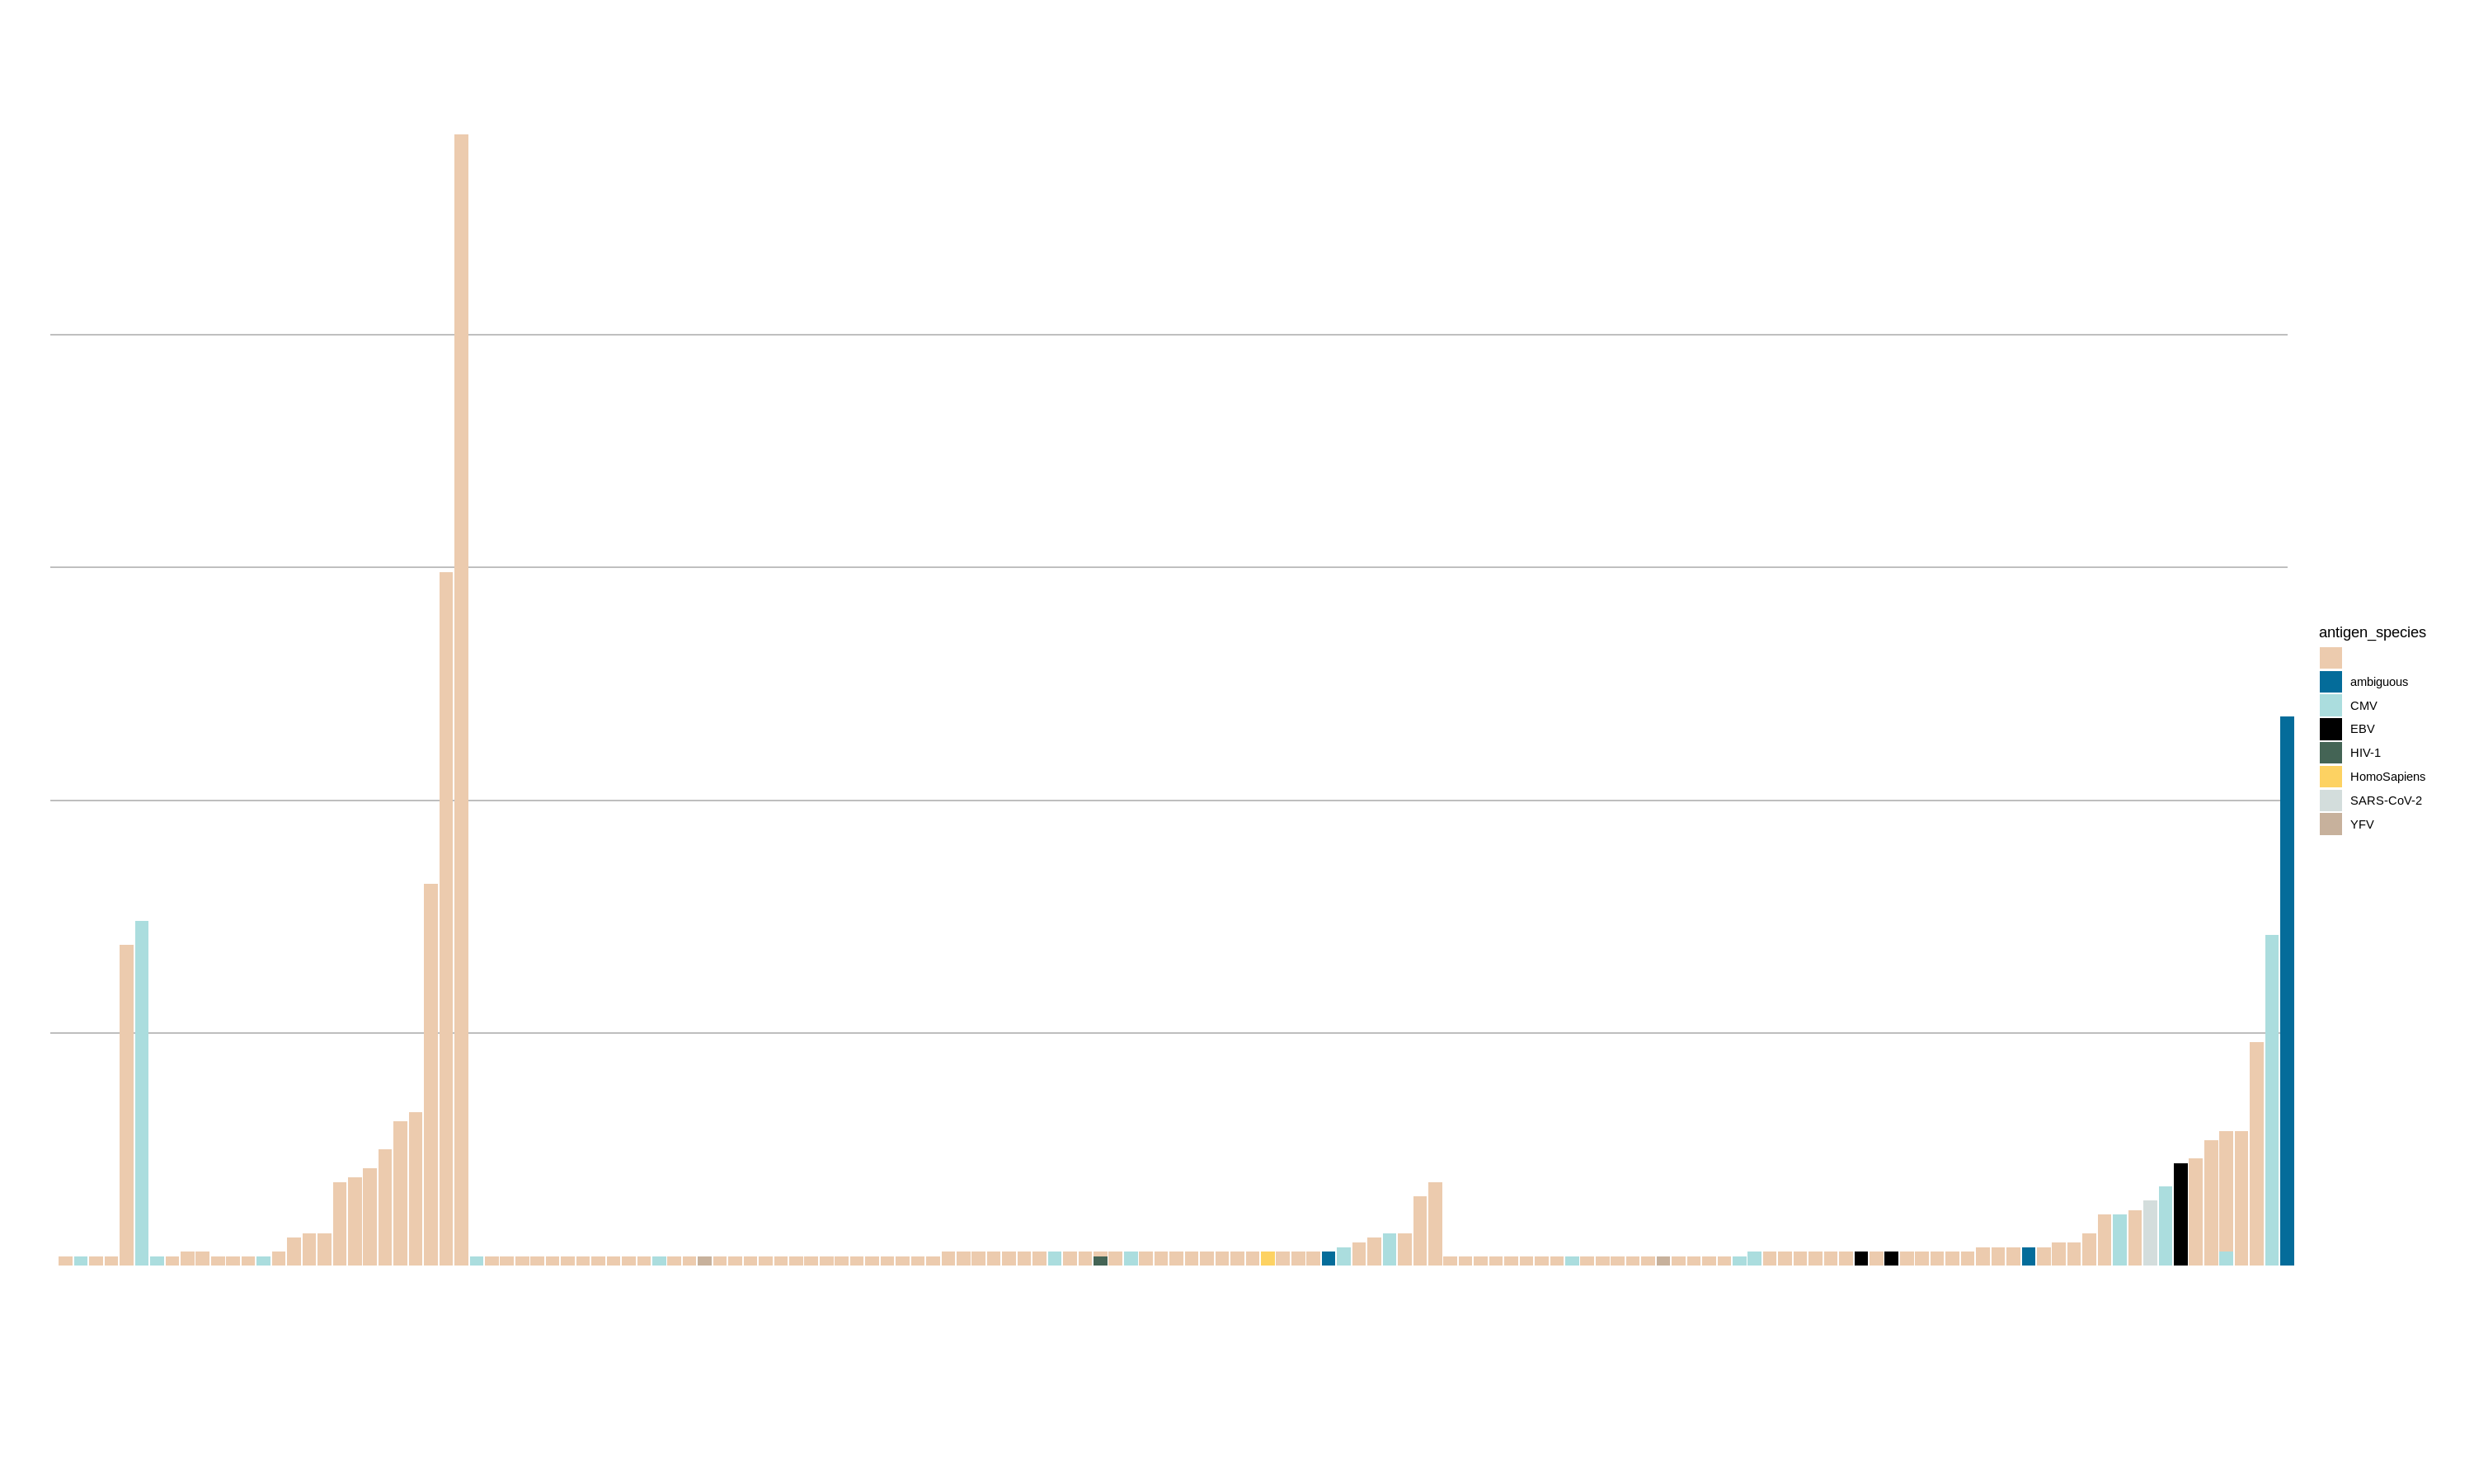

In [211]:
options(repr.plot.width=25, repr.plot.height=15)
ggplot(plot_data, aes(x=clone_id, y=count, fill = antigen_species)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar

  geom_bar(stat="identity") +

  ylim(-20,250) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid = element_blank(),
#   plot.margin = unit(rep(-1,4), "cm"),
#    legend.position = 'none',
    plot.margin=unit(c(1,1,1.5,1.2),"cm")) + 
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 50, yend = 50), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 100, yend = 100), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 150, yend = 150), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_segment(data=plot_data, aes(x = 0, xend = length(unique(clone_id)), y = 200, yend = 200), colour = "grey", alpha=1, size=0.3 , inherit.aes =TRUE ) +
geom_bar(stat="identity") +
scale_fill_manual(values = c("#ECCBAE", "#046C9A",  "#ABDDDE", "#000000", "#446455", "#FDD262", "#D3DDDC", "#C7B19C"))
#scale_y_break(c(150, 240))+
#coord_polar(start = 0)
#scale_y_log10()+ 
#theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size =10))
                                      
setwd('/home/jovyan/data/GCA/figures')
ggsave('clones_with_viral_link.png', dpi = 300, width = 49)